In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import  PIL
from PIL import Image
import os
%matplotlib inline

In [42]:
VEHICLES = 10 # Data encoding in the segmented image
ROADS = 7
ROAD_LINES = 6

def isolate_cars(filename,i):
    img = Image.open(filename)

    img_np = np.array(img)

    img_np_R = img_np[:,:,0] # Pull out R channel

    img_np_R[img_np_R == VEHICLES] = 255    

    img_np_R[img_np_R != 255] = 0
    
    h,w = img_np_R.shape
    img_np_R[int(.82*h):h, :] = 0

    new_img = np.stack((img_np_R,img_np_R,img_np_R), axis=-1)
    
    image = Image.fromarray(new_img, 'RGB')
    dest = 'mask/'
    image.save(dest+str(i)+'.png')
    return image

In [32]:
i=0
for subdir, dirs, files in os.walk('../lyft_training_data/Train/CameraSeg'):
    for file in files:
        isolate_cars(os.path.join(subdir, file),i)
        i=i+1

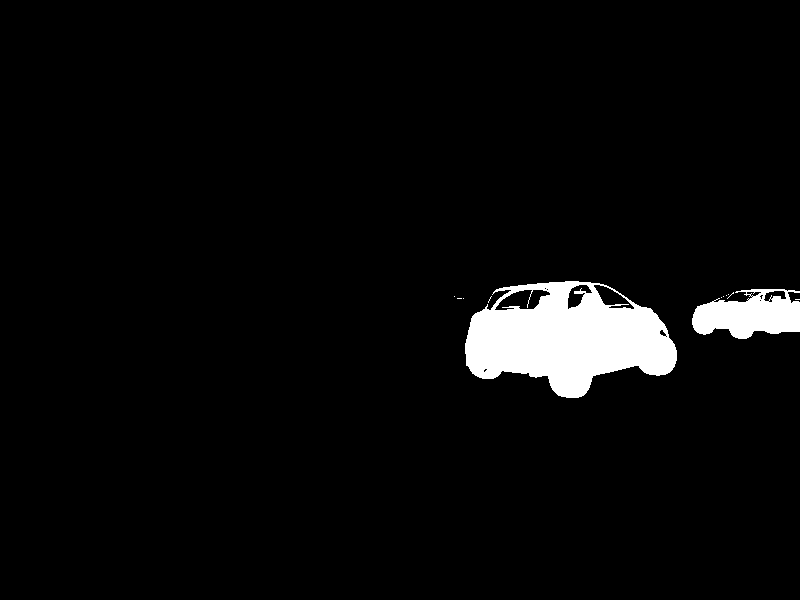

In [4]:
image=Image.open('../mask/559.png')
image


In [72]:
def preprocess_labels(label_image,obj):
    # Identify lane marking pixels (label is 6)
    lane_marking_pixels = (label_image[:,:,0] == ROAD_LINES).nonzero()
    road_pixels = (label_image[:,:,0] == ROADS).nonzero()
    # Set lane marking pixels to road (label is 7)
    labels_new = np.zeros_like(label_image)
    #labels_new = np.copy(label_image)
    labels_new[lane_marking_pixels] = ROADS
    if obj=='road' or obj=='both':
        labels_new[road_pixels] = ROADS
 
    # Identify all vehicle pixels
    vehicle_pixels = (label_image[:,:,0] == VEHICLES).nonzero()
    if obj == 'car' or obj=='both':
        labels_new[vehicle_pixels] = VEHICLES
    # Isolate vehicle pixels associated with the hood (y-position > 496)
    hood_indices = (vehicle_pixels[0] >= 496).nonzero()[0]
    hood_pixels = (vehicle_pixels[0][hood_indices], \
                   vehicle_pixels[1][hood_indices])
    # Set hood pixel labels to 0
    labels_new[hood_pixels] = 0
    # Return the preprocessed label image 
    return labels_new

In [73]:
image = cv2.imread("../lyft_training_data/Train/CameraSeg/900.png")

#image = mpimg.imread("../lyft_training_data/Train/CameraSeg/0.png")
image1= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

[]

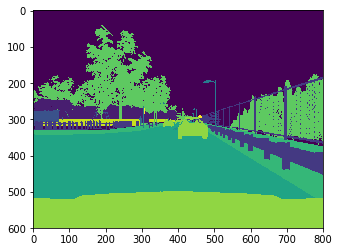

In [74]:
plt.imshow(image1[:,:,0])
plt.plot()

[]

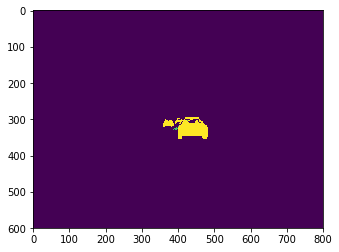

In [78]:
pre = preprocess_labels(image1,'car')
plt.imshow(pre[:,:,0])
plt.plot()